In [1]:
import pandas as pd
import geopandas as gpd
from _bootstrap import *
from paths import get_paths

from community_detection import (
    MatrixConstructor,
    GraphConstructor,
    NXGraphConstructor,
    CommunityDetector,
    PolygonDissolver,
    GraphPlotter
)
input_dir, output_dir,  plots_dir = get_paths()

In [2]:
target_pop = 300

matrix = pd.read_parquet(output_dir / "matrices.parquet")

# Select matrix
matrix = matrix.loc[matrix["target_pop"]==target_pop].copy()

tracts = gpd.read_file(output_dir / "tracts.gpkg", layer=f"tracts_{target_pop}")

mc = MatrixConstructor(tracts_gdf=tracts,
                       patient_data_path= input_dir / 'synthetic_phc_consultations_2023.parquet',
                       locations_data_path= input_dir / 'synthetic_points.parquet', 
                       health_centres_path=input_dir / "Establecimientos DEIS MINSAL 29-04-2025.xlsx")
mc.load_tracts()
mc.load_patient_data()
mc.load_health_centres()

matrix["TractID_1"] = matrix["TractID_1"].astype(str)
matrix["TractID_2"] = matrix["TractID_2"].astype(str)
tracts["TractID"] = tracts["TractID"].astype(str)

In [3]:
# Create PCSAs
gc = GraphConstructor(matrix, weights_col="visit_share")
gc.build_graph()
G = gc.get_graph()

cd = CommunityDetector(G, tracts, trials=30)
result, score, time = cd.run_infomap(return_codelength=True, preferred_modules=39, measure_time=True,
                                     enforce_spatial=True, strategy="strongest_connection", verbose=False)

df = pd.DataFrame(result.items(), columns=["TractID", "community"])

polygon_dissolver = PolygonDissolver(tracts)
pcsa = polygon_dissolver.process_community_outcomes(communities=df, verbose=False)

In [4]:
centres_assignment = mc.assign_tracts(mc.health_centres, "care_cen_code", "TractID_2")
centres_assignment["TractID_2"] = centres_assignment["TractID_2"].astype(str)

# TractID_2 is the location of a health centre
m1 = matrix.merge(centres_assignment, on="TractID_2", how="left")
m1 = m1[["TractID_2", "care_cen_code", "n_visits"]]  # Keep only relevant columns

# Aggregate total visits per (care centre, TractID) pair
visits_by_centre_and_tract = (
    m1
    .groupby(["care_cen_code", "TractID_2"], as_index=False)["n_visits"]
    .sum()
)

In [5]:
visits_by_centre_and_tract.head()

,care_cen_code,TractID_2,n_visits
0,114102,1193,55221
1,114301,3615,344330
2,114302,2869,120564
3,114303,798,158526
4,114304,2544,132467


In [6]:
urb_comms = ['PUENTE ALTO', 'SAN RAMÓN', 'LA FLORIDA', 'LA PINTANA', 'LA GRANJA']
communes = gpd.read_file(input_dir / "COMUNA_C17.shp")
communes = communes.to_crs(32719)
communes_urb = communes.loc[communes.NOM_COMUNA.isin(urb_comms)]
geometry = communes_urb.dissolve().geometry.iloc[0]

matrix["TractID_1"] = matrix["TractID_1"].astype(str)
matrix["TractID_2"] = matrix["TractID_2"].astype(str)

gc = NXGraphConstructor(matrix, weights_col="n_visits")
gc.build_graph()
G = gc.get_graph()

In [8]:
visits_by_centre_and_tract.head()

,care_cen_code,TractID_2,n_visits
0,114102,1193,55221
1,114301,3615,344330
2,114302,2869,120564
3,114303,798,158526
4,114304,2544,132467


In [10]:
matrix.head()

,TractID_1,TractID_2,n_visits,visit_share,visits_norm,visit_share_norm,combined_score,lon_1,lat_1,lon_2,lat_2,target_pop
52300,3,703,142,17.392857,0.040274,0.057106,0.048690,354622.500439,6.282158e+06,355664.009982,6.281077e+06,300
52301,3,798,3,1.000000,0.000571,0.003270,0.001920,354622.500439,6.282158e+06,351259.441487,6.289979e+06,300
52302,3,3126,5,1.000000,0.001143,0.003270,0.002206,354622.500439,6.282158e+06,355981.299151,6.279482e+06,300
52303,3,3159,26,1.000000,0.007141,0.003270,0.005205,354622.500439,6.282158e+06,351107.667577,6.282834e+06,300
52304,3,3567,16,2.000000,0.004284,0.006554,0.005419,354622.500439,6.282158e+06,352063.773698,6.281951e+06,300


c:\Users\fport\miniconda3\envs\dissertation\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


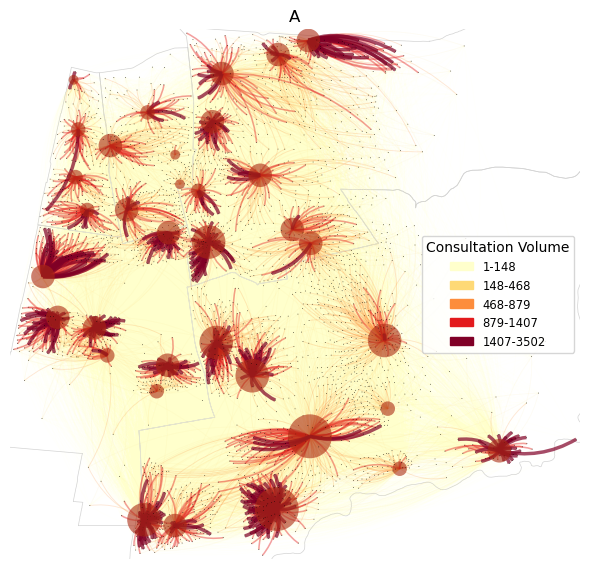

In [9]:
plotter = GraphPlotter()
plotter.plot_graph(
    graph=G,
    bbox=geometry,
    polygon_gdf=communes_urb,
    weights_col="weight",
    edge_alpha_min=0.05,
    edge_alpha_max=0.7,
    edge_width_min=0.5,
    edge_width_max=2.5,
    cmap_name="YlOrRd",
    node_size=0.3,
    vertex_color="black",
    add_basemap=False,
    polygon_edgecolor="lightgrey",
    polygon_linewidth=0.5,
    legend_title="Consultation Volume",
    health_centre_df=visits_by_centre_and_tract,
    health_centre_id_col="TractID_2",
    health_centre_value_col="n_visits",
    health_node_color="#AB2B13",
    health_node_size_min=50,
    health_node_size_max=1000,
    health_node_alpha=0.6,
    k_classes=5,
    figsize=(6, 6),
    zoom_to_nodes=True,
    title="A"
)


In [11]:
plotter.save_plot(plots_dir / "flows_urban_communes.png", dpi=200)

c:\Users\fport\miniconda3\envs\dissertation\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\fport\miniconda3\envs\dissertation\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


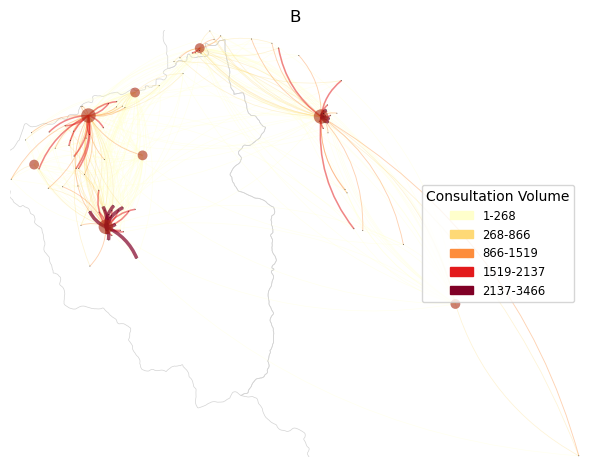

In [14]:
rur_comms = ['SAN JOSÉ DE MAIPO', 'PIRQUE']
communes_rur = communes.loc[communes.NOM_COMUNA.isin(rur_comms)]
geometry = communes_rur.dissolve().geometry.iloc[0]
plotter.plot_graph(
    graph=G,
    bbox=geometry,
    polygon_gdf=communes_rur,
    weights_col="weight",
    edge_alpha_min=0.3,
    edge_alpha_max=0.7,
    edge_width_min=0.5,
    edge_width_max=2.5,
    cmap_name="YlOrRd",
    node_size=0.3,
    vertex_color="black",
    add_basemap=False,
    polygon_edgecolor="lightgrey",
    polygon_linewidth=0.5,
    legend_title="Consultation Volume",
    health_centre_df=visits_by_centre_and_tract,
    health_centre_id_col="TractID_2",
    health_centre_value_col="n_visits",
    health_node_color="#AB2B13",
    health_node_size_min=50,
    health_node_size_max=1000,
    health_node_alpha=0.6,
    k_classes=5,
    figsize=(6, 6),
    zoom_to_nodes=True,
    title="B"
)

In [15]:
plotter.save_plot(plots_dir / "flows_rural_communes.png", dpi=200)